# Shortest Path - Minimum Flow

In [138]:
import numpy as np
from scipy.optimize import linprog
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from numpy import inf
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

# Problem Statement

You live very close to the university, which has caused you to always be overconfident, and despite your high motivation and commitment to studying, you always end up being late for the Optimization class. For this reason, you have decided to apply the knowledge you have acquired in the course to find a route that minimizes the time it takes you to get from your house to the university. To achieve your goal, you buy a map of the area. In this map, each intersection is a node such that the black dot symbolizes the coordinates [0, 0] and the green dot the coordinates [12, 6]. The map can be found in the image "map.png".

You decide to walk through all the streets of the sector, taking the time it takes to travel each street (time to get from one intersection to another), and you realize that these times coincide with the times generated by the function `get_time(initial_point, final_point, code)`, where `initial_point` is the coordinate of the intersection where you start timing, `final_point` is the coordinate of the intersection where you finish timing, and `code` is your identification code as a university student, written as a list of 9 digits.


### Function to find time between intersections

In [139]:
def get_time(initial_point, final_point, code):

    # Initialization
    np.random.seed(code)
    m, n = 13, 7
    p = np.random.rand(m, n)
    sigma = 50

    # Change format
    initial_point = np.array([int(i) for i in initial_point]).reshape(-1,1)
    final_point = np.array([int(i) for i in final_point]).reshape(-1,1)

    if sum(np.diag(cdist(initial_point, final_point, metric='cityblock'))) > 1 or np.all(
            final_point == initial_point) is True:
        return np.inf
    elif initial_point[0] > m or initial_point[0] < 0 or initial_point[1] > n or initial_point[1] < 0 :
        return "The initial point is outside the grid"
    elif final_point[0] > m or final_point[0] < 0 or final_point[1] > n or final_point[1] < 0 :
        return "The final point is outside the grid"

    elif len(code) != 9:
        return "Invalid code, it doesn't have 9 digits"
    else:
        c = 4
        for i in range(m):
            for j in range(n):
                if c < len(code) - 1:
                    c += 1
                else:
                    c = 5
                if code[c-1] != 0:
                    p[i, j] *= code[c]
        # With normal distribution
        negative = 1
        while negative:
            mu = p[initial_point[0], initial_point[1]] + p[final_point[0], final_point[1]]
            t = np.random.normal(mu, scale=sigma)
            if t > 0:
                negative = 0
    return t


### Function to draw and find minimum flow

In [140]:
def minimum_flow(M: np.array, b: np.array, m_grid=13, n_grid=7):

    # Format and initial variables
    b = b.reshape(-1, 1)
    m, n = M.shape
    G = nx.Graph()

    # Create graph from Distance Matrix
    for i in range(m):
        G.add_node(i + 1)
        for j in range(n):
            value = M[i, j]
            if value != np.inf:
                G.add_edge(i + 1, j + 1)
            # else:
            #     print("Arc {}->{} is not added".format(i+1, j+1))
    G = G.to_directed()

    # Create Adjacency matrix
    temp_M = np.zeros((m, n))
    indices_non_inf = np.where(M != np.inf)
    temp_M[indices_non_inf[0], indices_non_inf[1]] = 1
    A = []
    # Add by rows
    for i in range(m):
        temp = np.zeros((m, n))
        temp[i, :] = temp_M[i, :]
        temp[:, i] = temp_M[:, i] * -1
        temp[i, i] = 0
        row = temp.ravel()
        A.append(row)
    A = np.array(A)

    # Format for linear optimization
    M[M == np.inf] = 0
    c = M.ravel()
    bounds = [(0, None)] * len(c)

    # Solve
    res = linprog(c, A_eq=A, b_eq=b, bounds=bounds, method="simplex")
    print(res)

    # Create solution path
    X = res.x
    cost = res.fun

    X = X.reshape(m_grid * n_grid, m_grid * n_grid)
    result = np.where(X != 0)
    A, B = list(result[0] + 1), list(result[1] + 1)
    A.reverse()
    B.reverse()
    arcs = list(zip(A, B))

    # Labels for nodes
    pos = create_grid_layout(m_grid, n_grid)
    labels_pos = {k: np.array([0.3, 0.25]) + np.array(v) for k, v in pos.items()}

    # Restaurants
    x, y = [2, 1], [1, 5]
    plt.scatter(x, y, color='darkred', marker='s', s=120, zorder=90)

    # House
    x, y = [5], [4]
    plt.scatter(x, y, color='steelblue', marker='p', s=170, zorder=90)

    # University
    x, y = [11], [1]
    plt.scatter(x, y, color='gold', marker='d', s=160, zorder=90)

    # Draw graph
    labels = nx.draw_networkx_labels(G, pos=labels_pos, font_color="grey", font_size=10)
    nx.draw_networkx(G, pos, node_color='lightgray', node_size=12, with_labels=False)
    nx.draw_networkx_edges(G, pos, edgelist=arcs, edge_color='limegreen', width=4, arrowsize=6)

    plt.show()

    return cost, X, G

# Standard code
def create_grid_layout(n, m):
    dictionary = {}
    for node in range(n * m):
        index = np.unravel_index(node, (n, m))
        dictionary[node + 1] = index
    return dictionary


# Problem Solution

## Solve the problem of going from your home to the university in the minimum time.

### a) Mathematical formulation of the problem to be solved

In the problem to be solved, there are 91 nodes, where each node represents an intersection between different streets. The streets represent the arcs of the problem. Since each street is associated with a cost $c_{ij}$, representing the time it takes to travel this particular street, the objective is to find the streets that must be traveled to minimize the journey between home and the university. These streets, which indicate the optimal route for the journey, are represented by the flows $x_{ij}$.

Thus, the objective function of this optimization problem is the sum of the product of the costs of each arc $c_{ij}$ (travel time between each intersection) and the flows $x_{ij}$. The value of these flows will be 0 or 1 depending on whether that arc (street) is being considered as part of the optimal route.

The constraints for this optimization problem are related to the net flow between each node, or in this case, each intersection. This net flow for the first node (starting point) must be 1 because there is only one flow leaving this node, it must be -1 for the last node (arrival point) because there is only one flow entering this node, and it must be 0 for the rest of the intermediate nodes. In other words, the amount of flow entering a node must be equal to the amount of flow leaving it. This net flow amount is represented by the variables $b_i$.

In summary, the objective is to minimize the time it takes to travel from a particular starting point (home) to an arrival point (university), knowing that the net flow of each intersection must be 0 and that there is only one flow from the starting point and a negative flow at the arrival point. The mathematical formulation of the problem is shown below:

min $f(x) = \sum_{i=1}^{91}\sum_{j=1}^{91}c_{ij}x_{ij}$\
s.t.\
$\sum_{j=1}^{91}x_{ij} - \sum_{k=1}^{91}x_{ki} = b_i$

where 

$i = 1, ... ,91 $ 

and 

$b_{start} = 1$ (in this case $b_{start} = b_{1}$) \
$b_{end} = -1$ (in this case $b_{end} = b_{91}$) \
$b_i = 0$ for the other nodes.


### b) Construction of the adjacency matrix of the optimization problem


Information on how to flip the values within a matrix was found [here](https://numpy.org/doc/stable/reference/generated/numpy.flip.html).

In [141]:
# Adjacency matrix and an auxiliary matrix to indicate the node number corresponding to each intersection on the map are created.
A = np.zeros((91, 91))
aux = np.zeros((13, 7))

# Fill the auxiliary matrix with ascending numbers so that each component of this matrix represents the number of the node corresponding to that intersection.
c = 1
for i in range(0, np.shape(aux)[0]):
    for j in range(np.shape(aux)[1]):
        aux[i, j] = c
        c += 1
print(f'Auxiliary matrix:\n{aux}')

# Flip the transpose of the original auxiliary matrix so that the components match the coordinate system described in the guide.
aux2 = np.flip(aux.transpose(), 0)
print(f'\nFlipped and transposed auxiliary matrix (aux2):\n{aux2}')

# Traverse the auxiliary matrix aux2 to fill the adjacency matrix. The indices start at 1 to match the numbering assigned to the nodes. Consequently, 1 must be subtracted from each of the indexed positions within the A and aux2 matrices.
for i in range(1, np.shape(aux2)[0] + 1):
    for j in range(1, np.shape(aux2)[1] + 1):
        # If the current component has a neighbor below
        if i + 1 <= np.shape(aux2)[0]:
            # Determine which index of the adjacency matrix corresponds to the current component.
            x = int(aux2[i - 1, j - 1])
            y = int(aux2[i - 1 + 1, j - 1])
            # Place a 1 in the position of the bottom neighbor in the adjacency matrix.
            A[x - 1, y - 1] = 1
        # If the current component has a neighbor above
        if i - 1 >= 1:
            # Determine which index of the adjacency matrix corresponds to the current component.
            x = int(aux2[i - 1, j - 1])
            y = int(aux2[i - 1 - 1, j - 1])
            # Place a 1 in the position of the top neighbor in the adjacency matrix.
            A[x - 1, y - 1] = 1
        # If the current component has a neighbor to the right
        if j + 1 <= np.shape(aux2)[1]:
            # Determine which index of the adjacency matrix corresponds to the current component.
            x = int(aux2[i - 1, j - 1])
            y = int(aux2[i - 1, j - 1 + 1])
            # Place a 1 in the position of the right neighbor in the adjacency matrix.
            A[x - 1, y - 1] = 1
        # If the current component has a neighbor to the left
        if j - 1 >= 1:
            # Determine which index of the adjacency matrix corresponds to the current component.
            x = int(aux2[i - 1, j - 1])
            y = int(aux2[i - 1, j - 1 - 1])
            # Place a 1 in the position of the left neighbor in the adjacency matrix.
            A[x - 1, y - 1] = 1

print(f'\nAdjacency matrix A:\n{A}')


Auxiliary matrix:
[[ 1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14.]
 [15. 16. 17. 18. 19. 20. 21.]
 [22. 23. 24. 25. 26. 27. 28.]
 [29. 30. 31. 32. 33. 34. 35.]
 [36. 37. 38. 39. 40. 41. 42.]
 [43. 44. 45. 46. 47. 48. 49.]
 [50. 51. 52. 53. 54. 55. 56.]
 [57. 58. 59. 60. 61. 62. 63.]
 [64. 65. 66. 67. 68. 69. 70.]
 [71. 72. 73. 74. 75. 76. 77.]
 [78. 79. 80. 81. 82. 83. 84.]
 [85. 86. 87. 88. 89. 90. 91.]]

Flipped and transposed auxiliary matrix (aux2):
[[ 7. 14. 21. 28. 35. 42. 49. 56. 63. 70. 77. 84. 91.]
 [ 6. 13. 20. 27. 34. 41. 48. 55. 62. 69. 76. 83. 90.]
 [ 5. 12. 19. 26. 33. 40. 47. 54. 61. 68. 75. 82. 89.]
 [ 4. 11. 18. 25. 32. 39. 46. 53. 60. 67. 74. 81. 88.]
 [ 3. 10. 17. 24. 31. 38. 45. 52. 59. 66. 73. 80. 87.]
 [ 2.  9. 16. 23. 30. 37. 44. 51. 58. 65. 72. 79. 86.]
 [ 1.  8. 15. 22. 29. 36. 43. 50. 57. 64. 71. 78. 85.]]

Adjacency matrix A:
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1.

### c) Construction of matrix M, where each non-zero value in the adjacency matrix is replaced by the cost/time of the corresponding arc. If the arc does not exist, the corresponding value is replaced by $\infty$.


Information on how to access the indices of a specific value within a matrix was found [here](https://thispointer.com/find-the-index-of-a-value-in-numpy-array/).

Information on how to construct a matrix of tuples was found [here](https://stackoverflow.com/questions/8024750/numpy-cant-build-a-2-d-array-of-tuples).

In [142]:
# Create matrix M.
M = A.copy()

# Create a matrix of tuples, where each position will represent a point in the coordinate system described in the guide.
C = np.empty((7, 13), object)
for i in range(np.shape(C)[0]):
    for j in range(np.shape(C)[1]):
        C[i, j] = (j, i)

# Flip this matrix so that the coordinate positions match the system described in the guide.
tuplas = np.flip(C, 0)

# Traverse matrix M to replace necessary values. Once again, indices start at 1, and as a consequence, 1 is subtracted from each of the indexed positions within matrix M.
for i in range(1, len(M) + 1):
    for j in range(1, len(M) + 1):
        # Replace the 1s in the adjacency matrix with the costs associated with the corresponding pair of nodes.
        if M[i - 1, j - 1] == 1:
            # The 'source' matrix is a matrix filled with infinities except for the positions where the 'aux2' matrix
            # has the value equal to the index of the source node where the 1 was found in the adjacency matrix. The same
            # happens with the 'destination' matrix.
            source = np.where((aux2 == i), i, np.inf)
            destination = np.where((aux2 == j), j, np.inf)
            # Within the 'source' and 'destination' matrices, it is determined in which indices there is a value different from infinity
            # (there will always be only 1 value different from infinity). These indices represent the position within the tuple
            # matrix where the corresponding coordinate of both the source node and the destination node will be found.
            f = np.where(source != np.inf)
            d = np.where(destination != np.inf)
            # The corresponding coordinate is extracted from the tuple matrix for both the source node and the destination node based
            # on the indices found previously.
            origin = tuplas[f[0], f[1]][0]
            destination = tuplas[d[0], d[1]][0]
            # The time between the pair of coordinates for each node is obtained, and the 1 that was in the adjacency matrix is replaced
            # by the corresponding time between the two nodes.
            M[i - 1, j - 1] = np.round(get_time(origin, destination, [2, 0, 1, 7, 3, 0, 4, 1, 8]), 2)
        # There are no connections between the same node, so its value in matrix M is set to infinity.
        if j - 1 == i - 1:
            M[i - 1, j - 1] = np.inf
        # The rest of the values that are neither flows nor infinities are converted to infinity.
        elif M[i - 1, j - 1] == 0:
            M[i - 1, j - 1] = np.inf

print(f'Matrix M:\n{M}')


Matrix M:
[[  inf 59.03   inf ...   inf   inf   inf]
 [59.03   inf 59.44 ...   inf   inf   inf]
 [  inf 59.44   inf ...   inf   inf   inf]
 ...
 [  inf   inf   inf ...   inf 59.63   inf]
 [  inf   inf   inf ... 59.63   inf 60.56]
 [  inf   inf   inf ...   inf 60.56   inf]]


### d) Construction of the vector $s$ representing the net flows within each node.


In [143]:
# Creation of the column vector.
n = np.shape(A)[0]
s = np.zeros((n, 1))

# Start the index at 1 to follow the notation used previously.
for k in range(1, len(s) + 1):
    # Since the minimum route will be found between the house and the university, a 1 is placed at the house node (node 40),
    # as it is the starting node, and a -1 is placed at the university node, which is the destination node and corresponds to
    # node 79. The rest of the components are zero because of how the vector s was initialized.
    if k == 40:
        s[k - 1] = 1
    elif k == 79:
        s[k - 1] = -1


### e) The `minimum_flow` function is used to find the shortest route between home and university. This shortest route is plotted.


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 560.47
       x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
     nit: 167


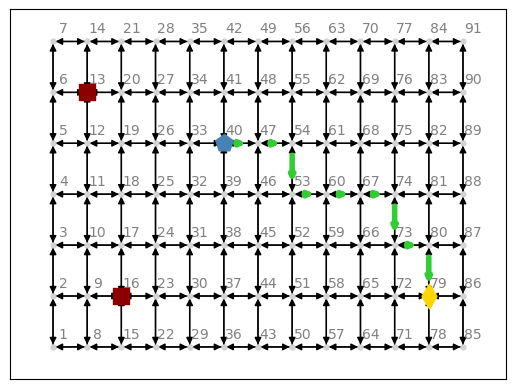

In [144]:
cost, X, G = minimum_flow(M,s)

According to the obtained result, the green arrows indicate the shortest route between home and university. It is found that the time it takes to travel this optimal route is 560.47 seconds, or **9.34 minutes**.
